In [ ]:
!pip install -U -q PyDrive

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!mkdir data

In [ ]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [ ]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [ ]:
commits = pd.io.sql.read_sql(
    "select timestamp from checker where uid like 'user_%'",
    conn, parse_dates=['timestamp']
    )

In [ ]:
conn.close()

In [ ]:
commits['date'] = commits['timestamp'].dt.floor('d')
commits['hour'] = commits['timestamp'].dt.hour
commits = commits.drop('timestamp', axis=1)

In [ ]:
commits.head()

,date,hour
0,2020-04-17,5
1,2020-04-17,5
2,2020-04-17,5
3,2020-04-17,5
4,2020-04-17,5


In [ ]:
working_day = commits.loc[commits['date'].dt.dayofweek < 5]['hour']
weekend = commits.loc[commits['date'].dt.dayofweek >= 5]['hour']
working_day = working_day.reset_index(drop=True)
weekend = weekend.reset_index(drop=True)

In [ ]:
working_day.head()

0    5
1    5
2    5
3    5
4    5
Name: hour, dtype: int64

In [ ]:
weekend.head()

0     7
1    13
2    13
3    13
4    13
Name: hour, dtype: int64

In [ ]:
len(working_day)

2037

In [ ]:
len(weekend)

1170

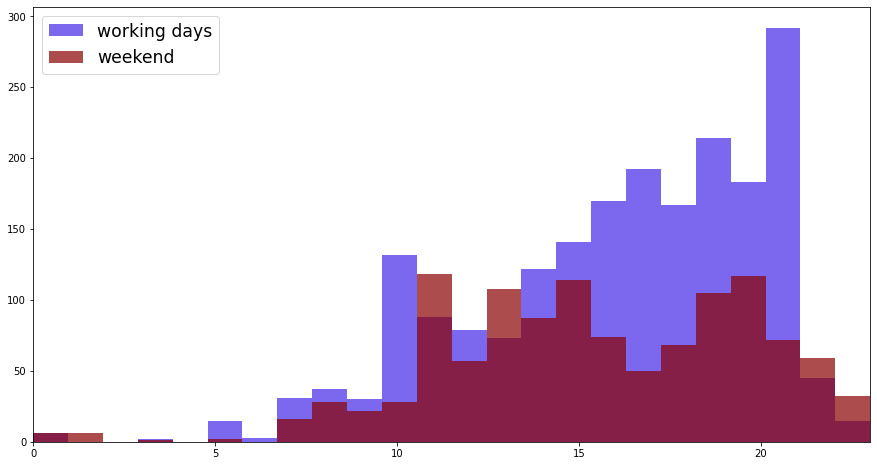

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(working_day, bins=24, label='working days', color='mediumslateblue')
ax.hist(weekend, bins=24, label='weekend', color='darkred', alpha=0.7)
ax.set_xlim(0, 23)
ax.legend(loc='upper left', fontsize='xx-large')
plt.show()

In [ ]:
df_1 = working_day.value_counts()
df_1 = df_1.sort_index()
df_1 = df_1.rename('working_day')
df_1 = df_1.to_frame()

In [ ]:
df_1.head()

,working_day
0,6
3,2
5,15
6,3
7,31


In [ ]:
df_2 = weekend.value_counts()
df_2 = df_2.sort_index()
df_2 = df_2.rename('weekend')
df_2 = df_2.to_frame()

In [ ]:
df_2.head()

,weekend
0,6
1,6
3,1
5,2
7,16


In [ ]:
df = df_1.join(df_2, how='inner')
df = df.rename_axis('hour')

In [ ]:
df.head()

,working_day,weekend
hour,,
0,6,6
3,2,1
5,15,2
7,31,16
8,37,28


In [ ]:
df.loc[df['working_day'] < df['weekend']]

,working_day,weekend
hour,,
11,88,118
13,73,108
22,45,59
23,15,32


Часы, в которые суммарное количество коммитов в будни больше, чем в выходные: 11, 13, 22, 23